In [1]:
import torch
from torch.utils.data import DataLoader
from data.oxford_dataset import OxfordDataset
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
import os

In [2]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 0.1,
                'current_decay' : 1,
                'voltage_decay' : 0.1,
                'requires_grad' : True,     
            }
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params, 200, 256),
                slayer.block.cuba.Dense(neuron_params, 256, 200),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike

In [3]:
device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

training_set = OxfordDataset()
train_loader = DataLoader(dataset=training_set, batch_size=1)

In [4]:
error = slayer.loss.SpikeTime(time_constant=2, filter_order=2).to(device)
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats)

In [5]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

epochs = 500

for epoch in range(epochs):
    for i, (input, target) in enumerate(train_loader): # training loop
        output = assistant.train(input, target)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
    
    if stats.training.best_loss:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')

/home/gregorlenz/anaconda3/envs/lava/lib/python3.9/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(
/home/gregorlenz/anaconda3/envs/lava/lib/python3.9/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[Epoch 499/500] Train loss = 60098.70312 (min = 59500.41406)))

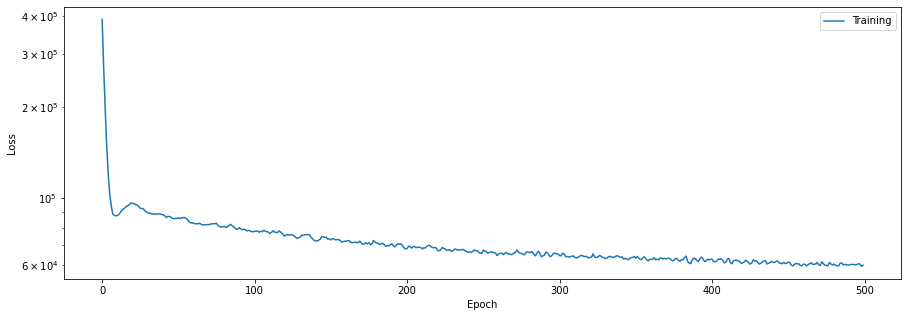

In [6]:
stats.plot(figsize=(15, 5))